--- 1. Carregando e Preparando o Dataset ---
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Dataset baixado em: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Shape do DataFrame: (50000, 2)
Limpeza de texto concluída.

--- 2. Modelagem de Tópicos com LDA ---
Tópicos encontrados pelo LDA:
Tópico 1:  ['movie', 'like', 'film', 'good', 'bad', 'really', 'movies', 'time', 'watch', 'people']
Tópico 2:  ['film', 'movie', 'great', 'good', 'story', 'love', 'like', 'character', 'time', 'best']
Tópico 3:  ['film', 'movie', 'story', 'like', 'people', 'time', 'films', 'characters', 'life', 'way']
Tópico 4:  ['film', 'man', 'like', 'young', 'time', 'films', 'black', 'old', 'life', 'story']
Tópico 5:  ['man', 'film', 'gets', 'like', 'good', 'time', 'killer', 'episode', 'house', 'police']

--- 3. Classificação Usando Tópicos LDA como Features ---
Shape da matriz de features do LDA: (50000, 5)

Resultados do RandomForest com Features LDA:
              precision

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


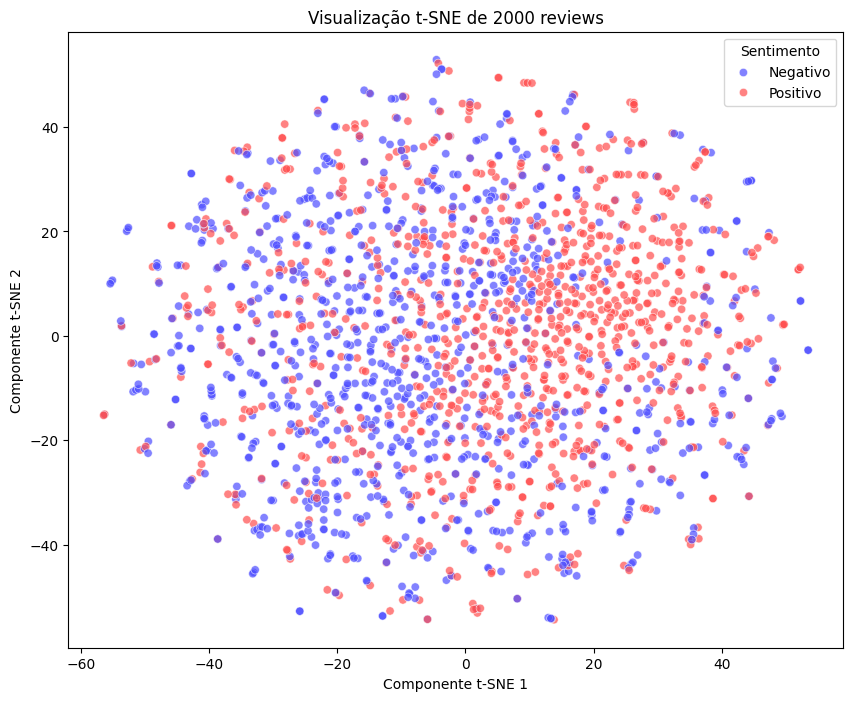


--- 7. Interpretação de Modelo com SHAP (Otimizado) ---
Criando amostra de fundo (background)...
Criando o explainer SHAP com o método 'interventional'...
Calculando o objeto SHAP Explanation...
Cálculo concluído.
Gerando SHAP Summary Plot...


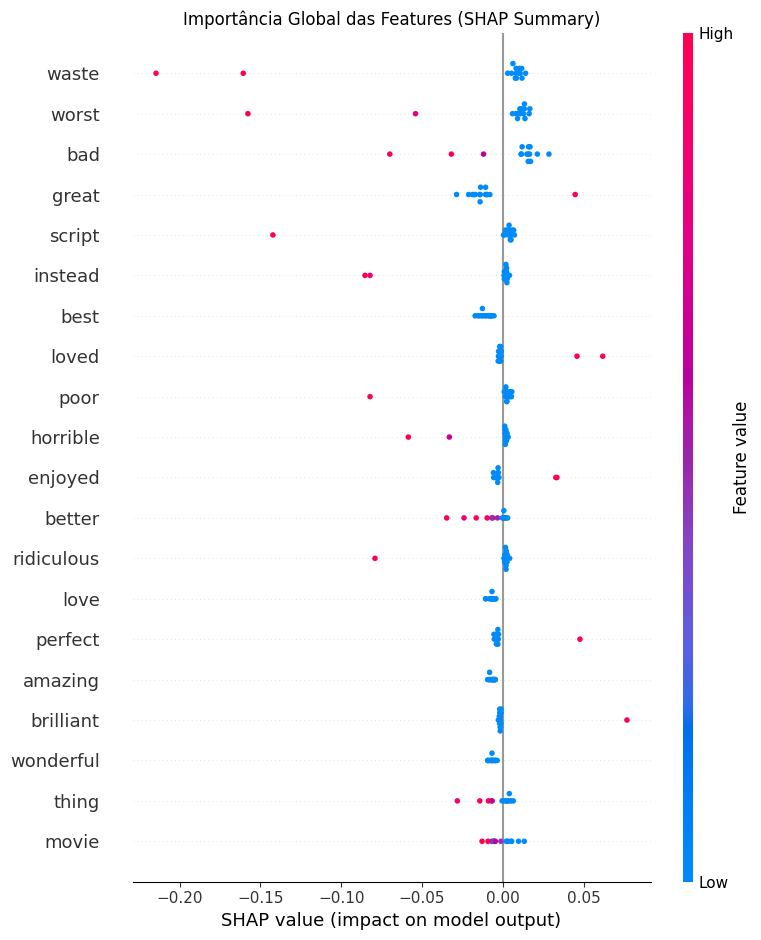


Gerando SHAP Force Plot para uma única instância...


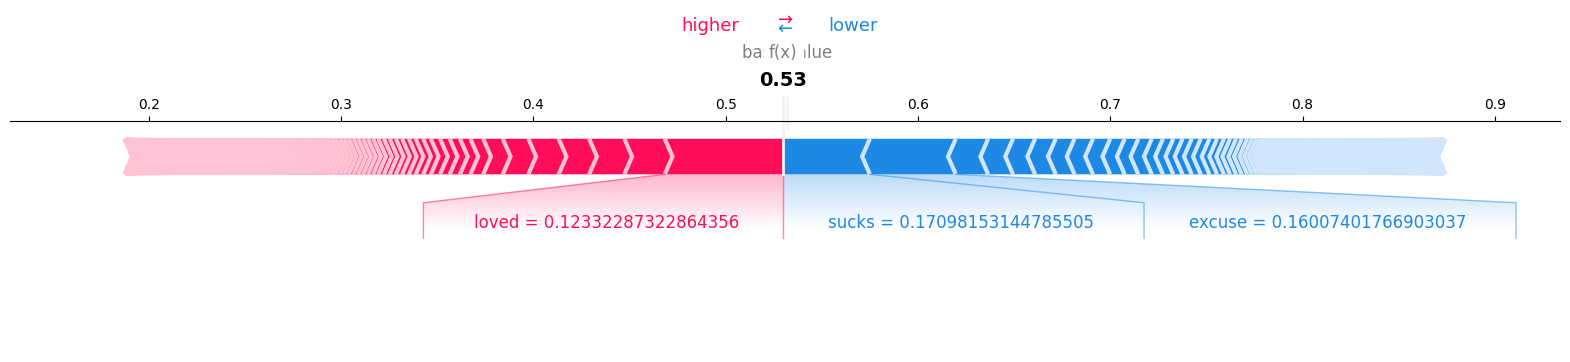

In [12]:
# ===================================================================
# INSTALAÇÃO DE PACOTES (execute no seu terminal ou célula de notebook)
# ===================================================================
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk shap lime kagglehub xgboost


# ===========================
# IMPORTS PRINCIPAIS
# ===========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Imports de Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

try:
  from xgboost import XGBClassifier
except:
  !pip install xgboost
  from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_auc_score

# Imports de NLTK
import nltk
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    print("Downloading NLTK 'stopwords' package...")
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
    print("Download complete.")

# Imports de Explicabilidade
try:
  import shap
  import lime
  from lime.lime_text import LimeTextExplainer
except:
  !pip install shap lime
  import shap
  import lime
  from lime.lime_text import LimeTextExplainer

# Import para carregar o dataset
import kagglehub


# ===========================
# 1. CARREGAR E PREPARAR O DATASET
# ===========================
print("--- 1. Carregando e Preparando o Dataset ---")
# Baixar o dataset IMDB via kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print(f"Dataset baixado em: {path}")

# Carregar CSV
csv_path = f"{path}/IMDB Dataset.csv"
df = pd.read_csv(csv_path)
print("Shape do DataFrame:", df.shape)

# Função de limpeza de texto
def clean_text(text: str) -> str:
    """
    Realiza a limpeza do texto:
    - Remove tags HTML
    - Mantém apenas caracteres alfabéticos
    - Converte para minúsculas
    - Remove stopwords e palavras com menos de 3 caracteres
    """
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    tokens = [w for w in text.split() if w not in STOPWORDS and len(w) > 2]
    return " ".join(tokens)

# Aplicar a limpeza
df["clean_review"] = df["review"].apply(clean_text)
print("Limpeza de texto concluída.")


# ===========================
# 2. MODELAGEM DE TÓPICOS COM LDA
# ===========================
print("\n--- 2. Modelagem de Tópicos com LDA ---")
# LDA funciona melhor com contagem de palavras, por isso usamos CountVectorizer.
bow_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
bow = bow_vectorizer.fit_transform(df["clean_review"])

# Aplicar LDA do scikit-learn
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(bow)

# Função para exibir os principais termos de cada tópico
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Tópico {idx+1}: ", [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print("Tópicos encontrados pelo LDA:")
print_topics(lda, bow_vectorizer)


# =================================================================
# 3. CLASSIFICAÇÃO COM BASE NOS TÓPICOS DO LDA
# =================================================================
print("\n--- 3. Classificação Usando Tópicos LDA como Features ---")
X_lda = lda.transform(bow)
print(f"Shape da matriz de features do LDA: {X_lda.shape}")

y = df["sentiment"].map({"positive": 1, "negative": 0})

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(
    X_lda, y, test_size=0.2, random_state=42, stratify=y
)

rf_lda = RandomForestClassifier(random_state=42)
rf_lda.fit(X_train_lda, y_train_lda)
y_pred_lda = rf_lda.predict(X_test_lda)

print("\nResultados do RandomForest com Features LDA:")
print(classification_report(y_test_lda, y_pred_lda))
print(f"ROC-AUC com Features LDA: {roc_auc_score(y_test_lda, rf_lda.predict_proba(X_test_lda)[:,1]):.4f}")


# ===========================
# 4. CLASSIFICAÇÃO COM TF-IDF
# ===========================
print("\n--- 4. Classificação com Features TF-IDF ---")
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(df["clean_review"])

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# 4.1 Modelo RandomForest com parâmetros padrão
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)
y_pred_rf_default = rf_default.predict(X_test)
print("\nResultados do RandomForest Padrão com TF-IDF:")
print(classification_report(y_test, y_pred_rf_default))
print(f"ROC-AUC (RF Padrão): {roc_auc_score(y_test, rf_default.predict_proba(X_test)[:,1]):.4f}")

# 4.2 Modelo XGBoost com parâmetros padrão (para comparação)
xgb_default = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_default.fit(X_train, y_train)
y_pred_xgb_default = xgb_default.predict(X_test)
print("\nResultados do XGBoost Padrão com TF-IDF:")
print(classification_report(y_test, y_pred_xgb_default))
print(f"ROC-AUC (XGBoost Padrão): {roc_auc_score(y_test, xgb_default.predict_proba(X_test)[:,1]):.4f}")


# ========================================================================================
# 5. BUSCA DE HIPERPARÂMETROS E VALIDAÇÃO CRUZADA (PARA RANDOM FOREST)
# ========================================================================================
print("\n--- 5. Otimização de Hiperparâmetros com GridSearchCV ---")
start_time = time.time()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [30, None],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
end_time = time.time()
print(f"GridSearchCV concluído em {(end_time - start_time) / 60:.2f} minutos.")

print("\nMelhores parâmetros encontrados:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
print("\nResultados do RandomForest Otimizado com TF-IDF:")
print(classification_report(y_test, y_pred_best_rf))
print(f"ROC-AUC (RF Otimizado): {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.4f}")


# ===========================
# 6. VISUALIZAÇÃO COM t-SNE
# ===========================
print("\n--- 6. Visualização com t-SNE ---")
sample_size = 2000
indices = np.random.choice(X_tfidf.shape[0], sample_size, replace=False)
X_subset = X_tfidf[indices].toarray()
y_subset = y.iloc[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X_subset)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y_subset, palette=["#ff4d4d", "#4d4dff"], alpha=0.7
)
plt.title(f"Visualização t-SNE de {sample_size} reviews")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Sentimento", labels=["Negativo", "Positivo"])
plt.show()


# =================================================================================
# 7. INTERPRETAÇÃO COM SHAP (VERSÃO FINAL COM EXPLANATION OBJECT)
# =================================================================================
print("\n--- 7. Interpretação de Modelo com SHAP (Otimizado) ---")

# --- Setup (como antes) ---
print("Criando amostra de fundo (background)...")
feature_names = tfidf.get_feature_names_out()
background_sample_np = shap.sample(X_train, 200).toarray()
background_df = pd.DataFrame(background_sample_np, columns=feature_names)
X_test_sample_df = pd.DataFrame(X_test[:15].toarray(), columns=feature_names)

# --- CORREÇÃO: Usar a API moderna do SHAP ---

# 1. Criar o explainer (como antes).
print("Criando o explainer SHAP com o método 'interventional'...")
explainer_shap = shap.TreeExplainer(best_rf, background_df, feature_perturbation='interventional')

# 2. Calcular um 'Explanation' object em vez de 'shap_values'.
#    Este objeto contém tudo (valores, dados, nomes) de forma organizada.
print("Calculando o objeto SHAP Explanation...")
explanation = explainer_shap(X_test_sample_df)
print("Cálculo concluído.")

# 7.1 Summary Plot (visão global)
print("Gerando SHAP Summary Plot...")
plt.title("Importância Global das Features (SHAP Summary)")
# Plotar usando o 'Explanation' object. A sintaxe [:,:,1] seleciona os valores para a classe positiva (1).
shap.summary_plot(explanation[:,:,1], X_test_sample_df, show=False)
plt.show()

# 7.2 Force Plot (visão de uma instância)
print("\nGerando SHAP Force Plot para uma única instância...")
instance_index = 0
# O force_plot também fica mais simples com o 'Explanation' object.
shap.force_plot(
    explanation.base_values[instance_index][1], # Base value para a classe 1
    explanation.values[instance_index,:,1],     # SHAP values para a classe 1
    X_test_sample_df.iloc[instance_index,:],    # Feature values da instância
    matplotlib=True,
    show=True
)